In [37]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import zipfile
import shutil
import warnings
from typing import List
from typing import Tuple
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, LeakyReLU

from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model

seed = 1235
tf.random.set_seed(seed)

# Avoid OOM errors by setting GPU Memory Consumption Growth when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [64]:
def plot_metrics(model, *, names=['loss', 'val_loss', 'accuracy', 'val_accuracy', 'auc', 'val_auc']):
    """
    Plot training and validation metrics from a model's training history.
    
    This function creates a figure with three subplots showing the progression of different
    metrics (loss, accuracy, and AUC) over training epochs. Each subplot displays both the
    training and validation metrics for easy comparison.
    
    Parameters
    ----------
    model : tf.keras.callbacks.History
        The history object returned by model.fit() containing the training metrics.
        Should have the specified metrics in its history dictionary.
    names : list of str, optional
        List of metric names to plot. Should contain 6 strings in the order:
        [training_loss, val_loss, training_acc, val_acc, training_auc, val_auc].
        Default is ['loss', 'val_loss', 'accuracy', 'val_accuracy', 'auc', 'val_auc'].
        
    Returns
    -------
    None
        The function displays the plot but doesn't return any values.
        
    Raises
    ------
    KeyError
        If any of the specified metric names are not found in model.history.
    ValueError
        If the names list doesn't contain exactly 6 metrics.
        
    Examples
    --------
    >>> history = model.fit(x_train, y_train, validation_data=(x_val, y_val))
    >>> plot_metrics(history)
    
    >>> # With custom metric names
    >>> plot_metrics(history, names=['loss', 'val_loss', 'binary_accuracy', 
                                   'val_binary_accuracy', 'auc', 'val_auc'])
    
    Notes
    -----
    - The function creates a 1x3 grid of subplots with the following arrangement:
        1. Loss metrics (left)
        2. Accuracy metrics (middle)
        3. AUC metrics (right)
    - Training metrics are plotted in teal
    - Validation metrics are plotted in orange
    - The figure is created with a size of 10x5 inches and 300 DPI
    """
    # Validate input
    if len(names) != 6:
        raise ValueError("Expected 6 metric names, got {len(names)}")
    
    # Pre-fetch all data at once to avoid multiple dictionary lookups
    try:
        metrics_data = {name: model.history[name] for name in names}
    except KeyError as e:
        raise KeyError(f"Metric {e} not found in model history. Available metrics: {list(model.history.keys())}")
    
    # Create figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(10, 5), dpi=300)
    plt.suptitle('Performance Metrics', fontsize=15)
    
    # Define plot configurations
    plot_configs = [
        {'idx': 0, 'metrics': names[0:2], 'title': 'Loss', 'colors': ['teal', 'orange']},
        {'idx': 1, 'metrics': names[2:4], 'title': 'Accuracy', 'colors': ['teal', 'orange']},
        {'idx': 2, 'metrics': names[4:6], 'title': 'AUC', 'colors': ['teal', 'orange']}
    ]
    
    # Create plots using a loop
    for config in plot_configs:
        ax = axes[config['idx']]
        for metric, color in zip(config['metrics'], config['colors']):
            ax.plot(metrics_data[metric], color=color, label=metric)
        ax.set_title(config['title'], fontsize=10)
        ax.set_xlabel('Epochs')
        ax.legend(loc="upper left")
    
    plt.tight_layout()
    plt.show()

In [5]:
os.getcwd()

'/teamspace/studios/this_studio/EFlow Images/btagged_images_CNN'

In [6]:
# signal_main = pd.read_csv('/teamspace/studios/this_studio/Preprocessing Eflow Images/data/dataset3/sig_btagged2jets.txt', sep = '\t')
# background_main = pd.read_csv('/teamspace/studios/this_studio/Preprocessing Eflow Images/data/dataset3/bg_btagged2jets.txt', sep = '\t')

In [7]:
# columns = ['isophoton_Eta', 'isophoton_Phi', 'jet1_Eta', 'jet1_Phi', 'jet2_Eta', 'jet2_Phi']

In [8]:
# signal = signal_main[columns]
# background = background_main[columns]

In [11]:
signal = pd.read_csv('/teamspace/studios/this_studio/BDT/data/signal_bdt.txt', sep = '\t')
background = pd.read_csv('/teamspace/studios/this_studio/BDT/data/background_bdt.txt', sep = '\t')

In [13]:
data = pd.concat([signal, background], axis = 0)

## Shuffling the data
data = data.sample(frac=1, random_state=seed)

In [15]:
data.values

array([[ 32.1602    ,   4.58691831, 101.12352354,   1.        ],
       [ 67.4479    ,   5.68637488, 325.61130819,   0.        ],
       [ 49.7301    ,   1.14533664, 141.37874342,   0.        ],
       ...,
       [ 67.0442    ,   3.67697228, 167.17726366,   1.        ],
       [ 36.5321    ,   4.39180638, 104.95613426,   1.        ],
       [ 39.5457    ,   3.38669265, 237.92337605,   0.        ]])

In [16]:
X, y = data.values[:,:-1], data.values[:,-1]

In [22]:
train_size = int(len(data)*.7) #70% of total batches as training data
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

X_train, y_train = X[:train_size, :], y[:train_size]
X_test, y_test = X[train_size:(train_size+test_size), :], y[train_size:(train_size+test_size)]
X_val, y_val = X[(train_size+test_size):, :], y[(train_size+test_size):]

In [23]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [34]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)
val_dataset = val.batch(BATCH_SIZE)

# Model

In [73]:
inputs = Input(shape=(3,))
x = Flatten()(inputs)
x = Dense(64, activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

ann = tf.keras.Model(inputs=inputs, outputs=outputs)
ann.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337,537 (1.29 MB)

 Trainable params: 337,537 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
ann.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

logdir = '/teamspace/studios/this_studio/EFlow Images/btagged_images_CNN/ann'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

checkpoint_callback = ModelCheckpoint(
    filepath='ann.keras',
    save_weights_only=False,
    monitor='val_auc',              
    mode='auto',           
    save_best_only=True,
    verbose=2
)


ann_hist = ann.fit(train_dataset,
                 epochs = 100,
                 validation_data = val_dataset, 
                 callbacks = [tensorboard_callback, checkpoint_callback])

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5553 - auc_6: 0.5337 - false_negatives_6: 240.3571 - false_positives_6: 150.0000 - loss: 1.6432 - precision_6: 0.4115 - recall_6: 0.3202 - true_negatives_6: 418.6786 - true_positives_6: 113.9643 - val_accuracy: 0.6653 - val_auc_6: 0.7791 - val_false_negatives_6: 162.0000 - val_false_positives_6: 0.0000e+00 - val_loss: 0.5673 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_true_negatives_6: 322.0000 - val_true_positives_6: 0.0000e+00
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6193 - auc_6: 0.6705 - false_negatives_6: 283.5000 - false_positives_6: 55.7857 - loss: 0.6742 - precision_6: 0.5208 - recall_6: 0.1661 - true_negatives_6: 509.8929 - true_positives_6: 73.8214 - val_accuracy: 0.6777 - val_auc_6: 0.7604 - val_false_negatives_6: 133.0000 - val_false_positives_6: 23.0000 - val_loss: 0.5552 - val_precision_6: 0.5577 - val_recall_6: 0.1790 - val_true_negatives_6: 299.0000 - val_true_po

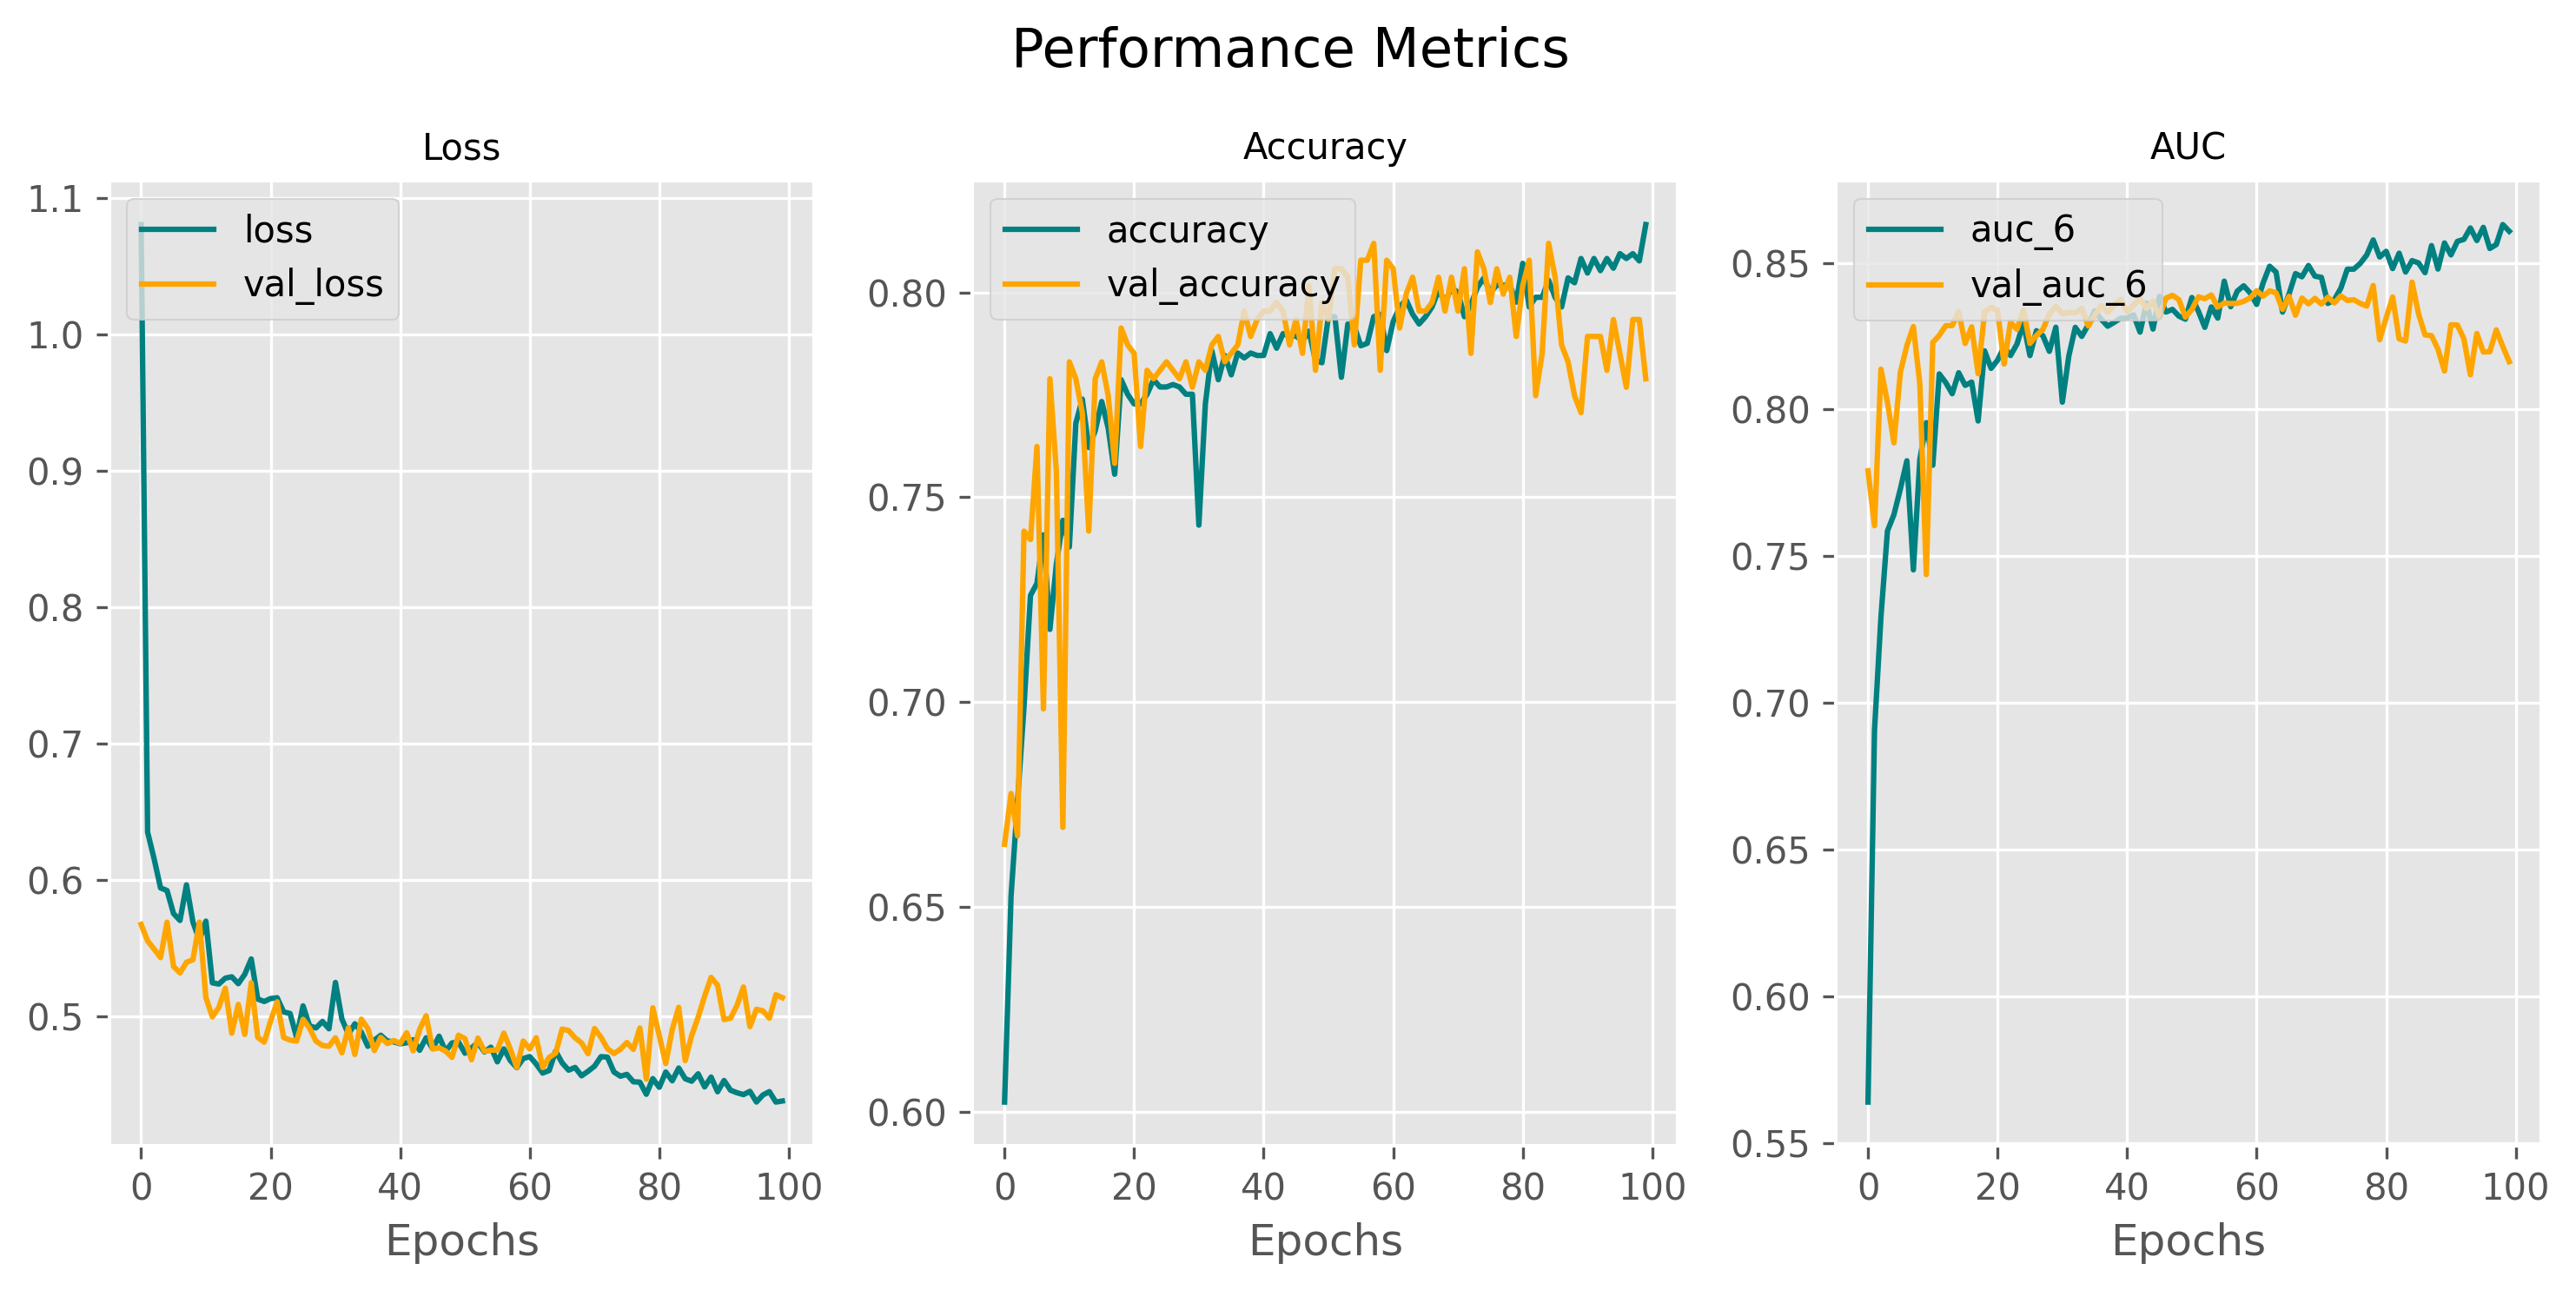

In [76]:
# eval_metrices = ann.evaluate(test_dataset)
plot_metrices(ann_hist, names = ['loss', 'val_loss', 'accuracy', 'val_accuracy', 'auc_6', 'val_auc_6'])

In [77]:
y_pred = ann.predict(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


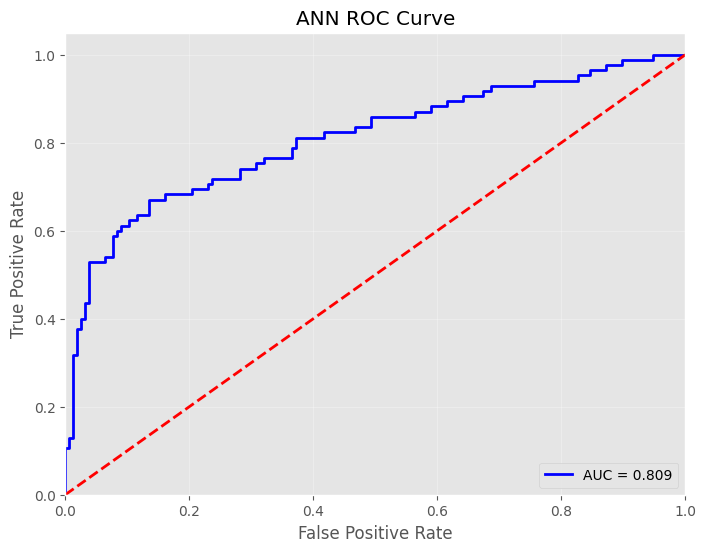

In [78]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    # Compute AUC
roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ANN ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()